### Deep Convolutional GANs (DCGAN)

In [1]:
%matplotlib inline
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
# Create the dataset
dataset = dset.ImageFolder(root='../data/celeba/',
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128,
                                         shuffle=True, num_workers=2)

In [3]:
device = torch.device('cuda:0')

In [4]:
batch_img, label = next(iter(dataloader))
batch_img.shape   # label = [0, 0, ... , 0]

torch.Size([128, 3, 64, 64])

- make_grid
    - normalize (bool, optional): If True, shift the image to the range (0, 1),
        by subtracting the minimum and dividing by the maximum pixel value.

In [5]:
xx = vutils.make_grid(batch_img[:16], nrow=4, normalize=True)

In [6]:
xx.shape

torch.Size([3, 266, 266])

In [7]:
xx = np.transpose(xx, (1,2,0))
xx.shape

torch.Size([266, 266, 3])

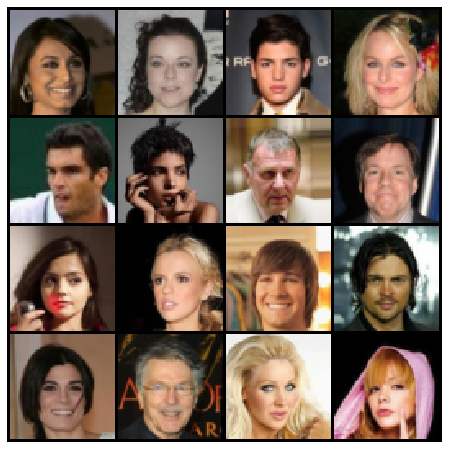

In [8]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(xx)

#### Network architecture

<img src=attachment:image.png width=600>
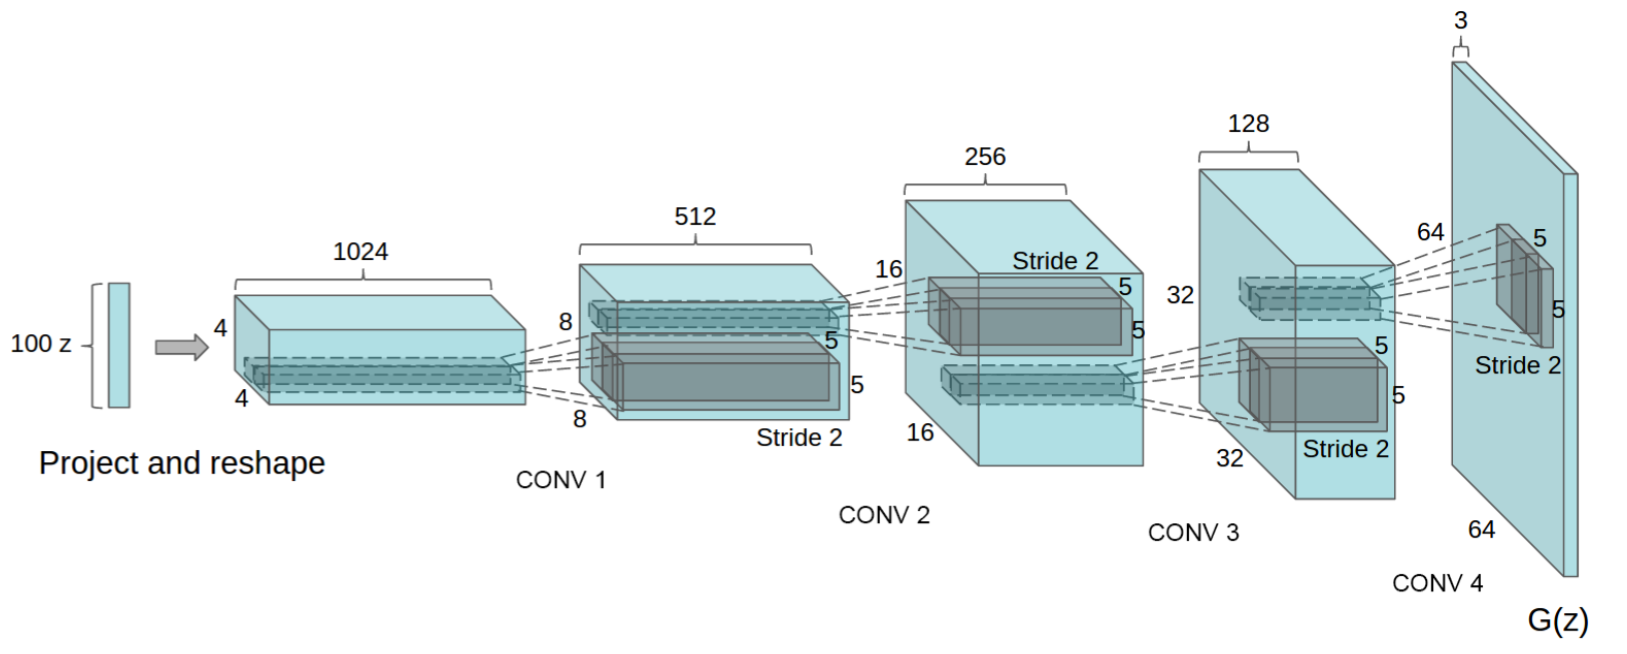

In [9]:
ngpu=4
z_dim = 100
num_featuremaps=64
lr = 0.0002

In [10]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            nn.ConvTranspose2d(in_channels=z_dim,out_channels=num_featuremaps * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_featuremaps * 8),
            nn.ReLU(True),
            # state size. (num_featuremaps*8) x 4 x 4
            nn.ConvTranspose2d(num_featuremaps * 8, num_featuremaps * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_featuremaps * 4),
            nn.ReLU(True),
            # state size. (num_featuremaps*4) x 8 x 8
            nn.ConvTranspose2d( num_featuremaps * 4, num_featuremaps * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_featuremaps * 2),
            nn.ReLU(True),
            # state size. (num_featuremaps*2) x 16 x 16
            nn.ConvTranspose2d( num_featuremaps * 2, num_featuremaps, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_featuremaps),
            nn.ReLU(True),
            # state size. (num_featuremaps) x 32 x 32
            nn.ConvTranspose2d(in_channels=num_featuremaps, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

- nn.DataParallel(module, device_ids=None, output_device=None, dim=0)
    - Implements data parallelism at the module level.

In [11]:
netG = Generator(ngpu).to(device)

# Handle multi-gpu
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

In [12]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(in_channels=3, out_channels=num_featuremaps, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (num_featuremaps) x 32 x 32
            nn.Conv2d(num_featuremaps, num_featuremaps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_featuremaps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (num_featuremaps*2) x 16 x 16
            nn.Conv2d(num_featuremaps * 2, num_featuremaps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_featuremaps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (num_featuremaps*4) x 8 x 8
            nn.Conv2d(num_featuremaps * 4, num_featuremaps * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_featuremaps * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (num_featuremaps*8) x 4 x 4
            nn.Conv2d(num_featuremaps * 8, 1, 4, 1, 0, bias=False),  #Fully-connected 대신에 Conv2d로 대체.
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [13]:
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

In [14]:
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(16, z_dim, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

$$\max_D log(D(x)) + log(1-D(G(z)))$$
$$\max_G log(D(G(z)))$$

In [15]:
num_epochs = 5

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)  # real_label =1
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, z_dim, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label) # fake_label=0
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if ((iters % 500 == 0) and (epoch < 3)) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, nrow=4, padding=2, normalize=True))

        iters += 1

[0/5][0/1583]	Loss_D: 1.4967	Loss_G: 1.3926	D(x): 0.4845	D(G(z)): 0.5316 / 0.2518
[0/5][50/1583]	Loss_D: 0.2252	Loss_G: 10.7074	D(x): 0.8448	D(G(z)): 0.0005 / 0.0001
[0/5][100/1583]	Loss_D: 0.0838	Loss_G: 6.9405	D(x): 0.9449	D(G(z)): 0.0107 / 0.0018
[0/5][150/1583]	Loss_D: 0.4495	Loss_G: 3.7958	D(x): 0.8567	D(G(z)): 0.2309 / 0.0265
[0/5][200/1583]	Loss_D: 0.9256	Loss_G: 2.3986	D(x): 0.7341	D(G(z)): 0.4274 / 0.1024
[0/5][250/1583]	Loss_D: 0.7162	Loss_G: 2.5821	D(x): 0.7041	D(G(z)): 0.2702 / 0.0864
[0/5][300/1583]	Loss_D: 1.1188	Loss_G: 2.3857	D(x): 0.7822	D(G(z)): 0.5145 / 0.1147
[0/5][350/1583]	Loss_D: 0.4069	Loss_G: 3.6753	D(x): 0.8803	D(G(z)): 0.2292 / 0.0325
[0/5][400/1583]	Loss_D: 0.7615	Loss_G: 3.1313	D(x): 0.8462	D(G(z)): 0.4174 / 0.0517
[0/5][450/1583]	Loss_D: 0.5482	Loss_G: 2.3851	D(x): 0.7067	D(G(z)): 0.1388 / 0.1075
[0/5][500/1583]	Loss_D: 0.6276	Loss_G: 3.5205	D(x): 0.9106	D(G(z)): 0.3756 / 0.0408
[0/5][550/1583]	Loss_D: 0.5342	Loss_G: 2.4504	D(x): 0.7615	D(G(z)): 0.1992 / 0

[3/5][100/1583]	Loss_D: 0.4534	Loss_G: 2.5980	D(x): 0.7598	D(G(z)): 0.1427 / 0.0953
[3/5][150/1583]	Loss_D: 0.6494	Loss_G: 3.6890	D(x): 0.9086	D(G(z)): 0.3927 / 0.0324
[3/5][200/1583]	Loss_D: 0.7010	Loss_G: 3.2996	D(x): 0.8369	D(G(z)): 0.3691 / 0.0471
[3/5][250/1583]	Loss_D: 0.5048	Loss_G: 2.0606	D(x): 0.7424	D(G(z)): 0.1569 / 0.1524
[3/5][300/1583]	Loss_D: 0.7393	Loss_G: 1.8120	D(x): 0.7155	D(G(z)): 0.2777 / 0.1960
[3/5][350/1583]	Loss_D: 1.2209	Loss_G: 5.6676	D(x): 0.9650	D(G(z)): 0.6422 / 0.0053
[3/5][400/1583]	Loss_D: 0.5189	Loss_G: 2.3919	D(x): 0.7738	D(G(z)): 0.2052 / 0.1100
[3/5][450/1583]	Loss_D: 0.5547	Loss_G: 2.6606	D(x): 0.8142	D(G(z)): 0.2619 / 0.0828
[3/5][500/1583]	Loss_D: 0.7665	Loss_G: 3.6499	D(x): 0.8932	D(G(z)): 0.4459 / 0.0329
[3/5][550/1583]	Loss_D: 0.5250	Loss_G: 2.0959	D(x): 0.8131	D(G(z)): 0.2436 / 0.1525
[3/5][600/1583]	Loss_D: 0.6843	Loss_G: 2.7968	D(x): 0.8566	D(G(z)): 0.3681 / 0.0815
[3/5][650/1583]	Loss_D: 0.5837	Loss_G: 2.0888	D(x): 0.6573	D(G(z)): 0.0974 /

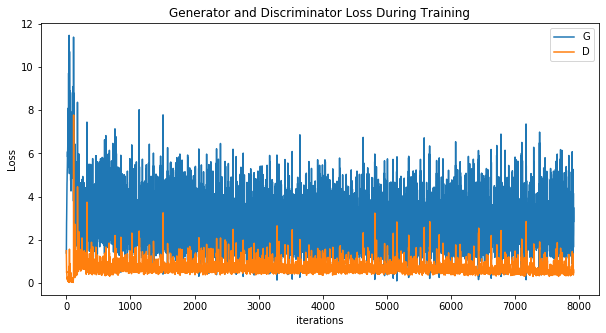

In [16]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

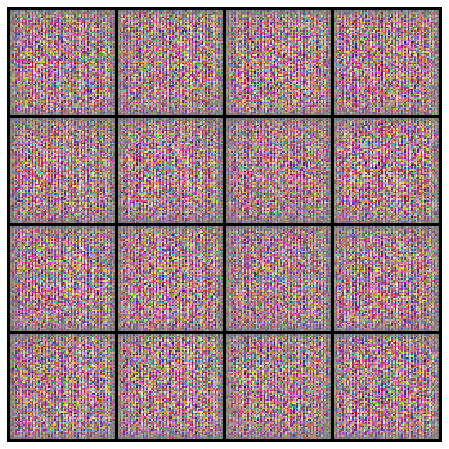

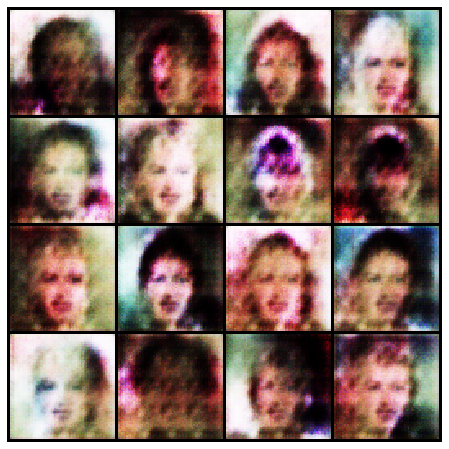

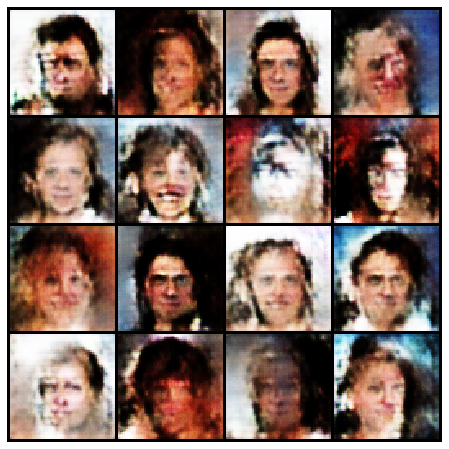

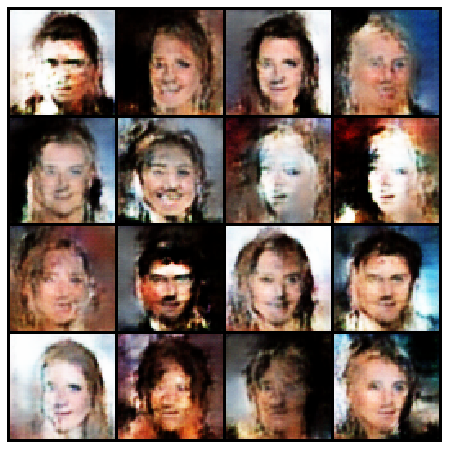

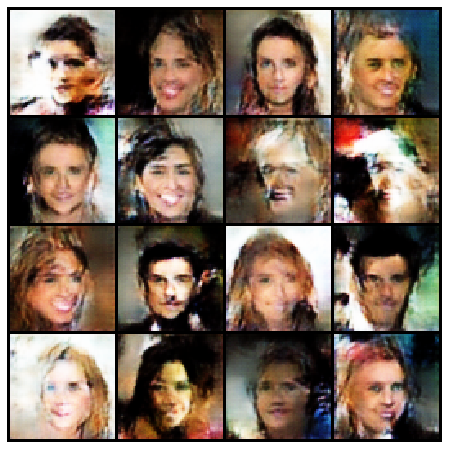

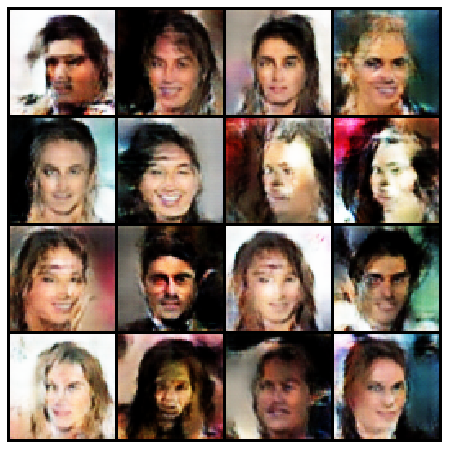

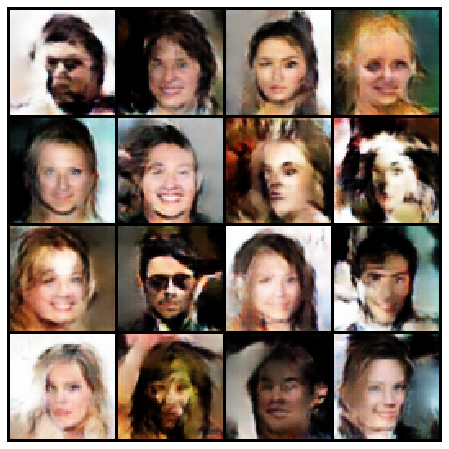

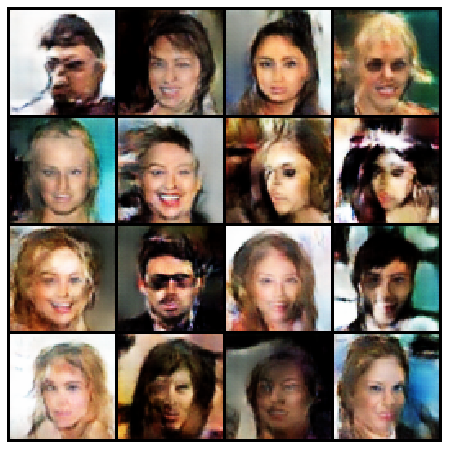

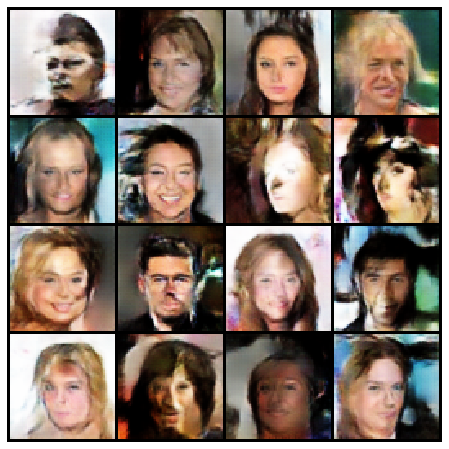

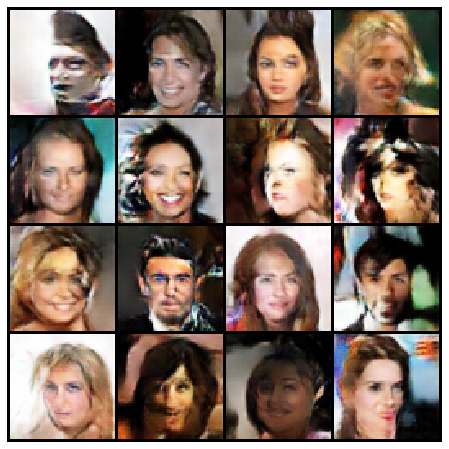

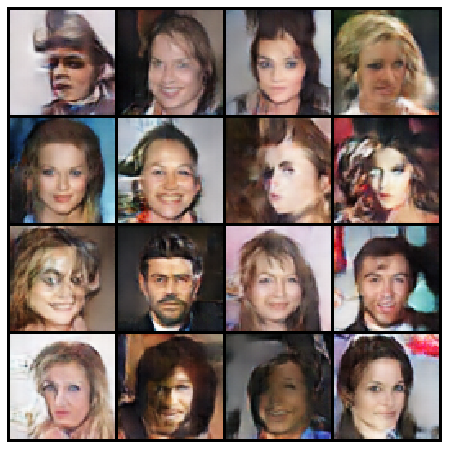

In [18]:
for i in img_list:
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.imshow(np.transpose(i,(1,2,0)), animated=True)
    plt.show()